In [2]:
import numpy as np
import pandas as pd

In [3]:
live = pd.read_csv('livecattle.csv')
live['Date'] = pd.to_datetime(live['Date'])
live = live.set_index(live['Date'])

feeder = pd.read_csv('feeder.csv')
feeder['Date'] = pd.to_datetime(feeder['Date'])
feeder = feeder.set_index(feeder['Date'])

corn = pd.read_csv('corn.csv')
corn['Date'] = pd.to_datetime(corn['Date'])
corn = corn.set_index(corn['Date'])

In [4]:
contract_codes = pd.Series({1: 'F', 2: 'G', 3: 'H', 4: 'J', 
                  5: 'K', 6: 'M', 7: 'N', 8: 'Q',
                  9: 'U', 10: 'V', 11: 'X', 12: 'Z'})
corn_contracts =    ['H', 'H', 'H', 'K', 'K', 'N', 'N', 'U', 'U', 'Z', 'Z', 'Z']
feeder_contracts =  ['F', 'H', 'H', 'J', 'K', 'Q', 'Q', 'Q', 'U', 'V', 'X', 'F']
live_contracts =    ['G', 'G', 'J', 'J', 'M', 'M', 'Q', 'Q', 'V', 'V', 'Z', 'Z']
live_contracts = live_contracts[5:] + live_contracts[:5]

In [5]:
def to_code(month_num):
    return contract_codes[month_num]

def to_num(letter_code):
    return pd.Index.tolist(contract_codes[contract_codes == letter_code].index)[0]

def get_current(month_num, l):
    return l[month_num - 1]

def get_next(month_num, l):
    return l[month_num % 12]

In [11]:
# Verify that the live cattle contracts expire approx. 4-6 months later than the corn and feeder contracts
#for i in range(12) :
#    print to_num(corn_contracts[i]), to_num(feeder_contracts[i]), to_num(live_contracts[i])

In [10]:
# Truncate data set to between 3/13/2012 to 1/31/2017, where we have consistent data across all contracts
corn = corn.truncate(before='3-13-2013', after='01-31-2017', axis =0)
corn_series = pd.Series(np.zeros(corn.shape[0]), index = corn['Date'])

live = live.truncate(before='3-13-2012, after='01-31-2017', axis=0)
live_series = pd.Series(np.zeros(live.shape[0]), index = live['Date'])

feeder = feeder.truncate(before='3-13-2012', after='01-31-2017', axis=0)
feeder_series = pd.Series(np.zeros(feeder.shape[0]), index = feeder['Date'])

Based on Goldman Sach's index roll procedure: 

on 1-4th business day of the month, return current month's contract price

on 5th business day, return .8 * current + .2 * next month's contract

on 6th business day, return .6 * current + .4 * next month's contract

on 7th business day, return .4 * current + .6 * next month's contract

on 8th business day, return .2 * current + .8 * next month's contract

on 9th-end, return next month's contract
       
on months where next contract is the same as the current contract, this 
process just returns the price of the current contract

on months where the next month's contract is different, this properly rolls the
contract to give us an "index" price

In [13]:
def series_fill(df, contracts, series):
    curMonth = 3 # dataset begins in oct 2011
    businessDay = 8
    for row in df.iterrows():

        month = row[1]['Date'].month
        year = row[1]['Date'].year

        if month != curMonth:
            businessDay = 0
            curMonth = month

        if curMonth == 2 and year == 2017:
            break;

        businessDay += 1 

        # get month code for the current contract 
        current_contract_month = get_current(month, contracts)

        # get month code for next month's contract 
        next_contract_month = get_next(month, contracts)

        # get year associated with current and next contract. 
            # if the contract month is greater than the current month
        # then we know the contract expires this year. 
            # otherwise we know the it's for a contract expiring next year
        current_contract_year = str(year+1)[-2:] if to_num(current_contract_month) < month else str(year)[-2:]
        next_contract_year = str(year+1)[-2:] if to_num(next_contract_month) < month else str(year)[-2:]


        #on 1-4th business day of the month, return current month's contract price
        if 1 <= businessDay <= 4:
            series[row[0]] = row[1][current_contract_month + current_contract_year]
        #on 5th business day, return .8 current + .2 next month's contract_codes
        elif businessDay == 5:
            series[row[0]] = row[1][current_contract_month + current_contract_year] *.8 + \
                row[1][next_contract_month + next_contract_year] * .2
        #on 6th business day, return .6 current + .4 next month's contract
        elif businessDay == 6:
            series[row[0]] = row[1][current_contract_month + current_contract_year] *.6 + \
                row[1][next_contract_month + next_contract_year] * .4
        #on 7th business day, return .4 current + .6 next month's contract
        elif businessDay == 7:
            series[row[0]] = row[1][current_contract_month + current_contract_year] *.4 + \
                row[1][next_contract_month + next_contract_year] * .6
        #on 8th business day, return .2 current + .8 next month's contract
        elif businessDay == 8:
            series[row[0]] = row[1][current_contract_month + current_contract_year] *.2 + \
                row[1][next_contract_month + next_contract_year] * .8
        #on 9th-end, return next month's contract
        else:
            series[row[0]] = row[1][next_contract_month + next_contract_year]
            
        #if series[row[0]] == 0 and year != 2017:
        #    print row[0]

In [14]:
series_fill(live, live_contracts, live_series)
series_fill(corn, corn_contracts, corn_series)
series_fill(feeder, feeder_contracts, feeder_series)

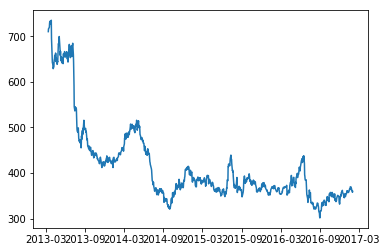

In [15]:
import matplotlib.pyplot as plt
plt.plot(corn_series)
plt.show()

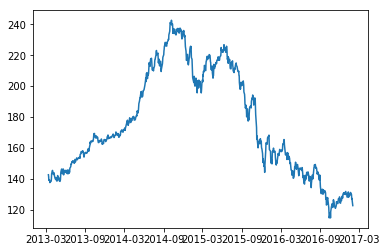

In [16]:
plt.plot(feeder_series)
plt.show()

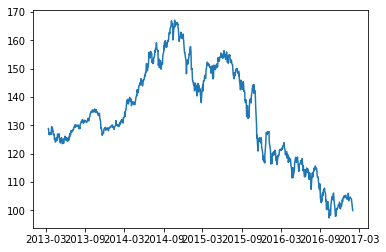

In [17]:
plt.plot(live_series)
plt.show()